In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install optuna > /dev/null

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [4]:
tf.random.set_seed(47)
np.random.seed(47)

In [5]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [6]:
plt.rcParams['figure.figsize'] = (16,6)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving ETSY.csv to ETSY.csv


In [8]:
df = pd.read_csv('ETSY.csv')
df['Date'] = pd.to_datetime(df.Date)

In [9]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date       Open      Close        Low       High  Adj Close
0 2015-04-17  29.770000  27.580000  26.510000  30.299999  27.580000
1 2015-04-20  28.770000  24.900000  24.870001  28.900000  24.900000
2 2015-04-21  24.969999  25.750000  24.559999  26.040001  25.750000
3 2015-04-22  26.000000  25.120001  24.950001  26.240000  25.120001
4 2015-04-23  24.930000  25.620001  24.080000  25.740000  25.620001


In [10]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,1310,1310.000000,1310.000000,1310.000000,1310.000000,1310.000000
mean,2017-11-21 04:12:49.465648896,30.831354,30.847958,30.120630,31.529176,30.847958
min,2015-04-17 00:00:00,6.370000,6.360000,6.040000,6.830000,6.360000
25%,2016-08-03 06:00:00,12.912500,12.905000,12.680000,13.192500,12.905000
50%,2017-11-18 12:00:00,19.295000,19.335000,18.901000,19.860000,19.335000
75%,2019-03-12 18:00:00,49.485000,49.547500,48.437500,50.485749,49.547500
max,2020-06-29 00:00:00,102.269997,102.889999,100.175003,104.279999,102.889999
std,NaN,21.706786,21.745211,21.212798,22.215466,21.745211


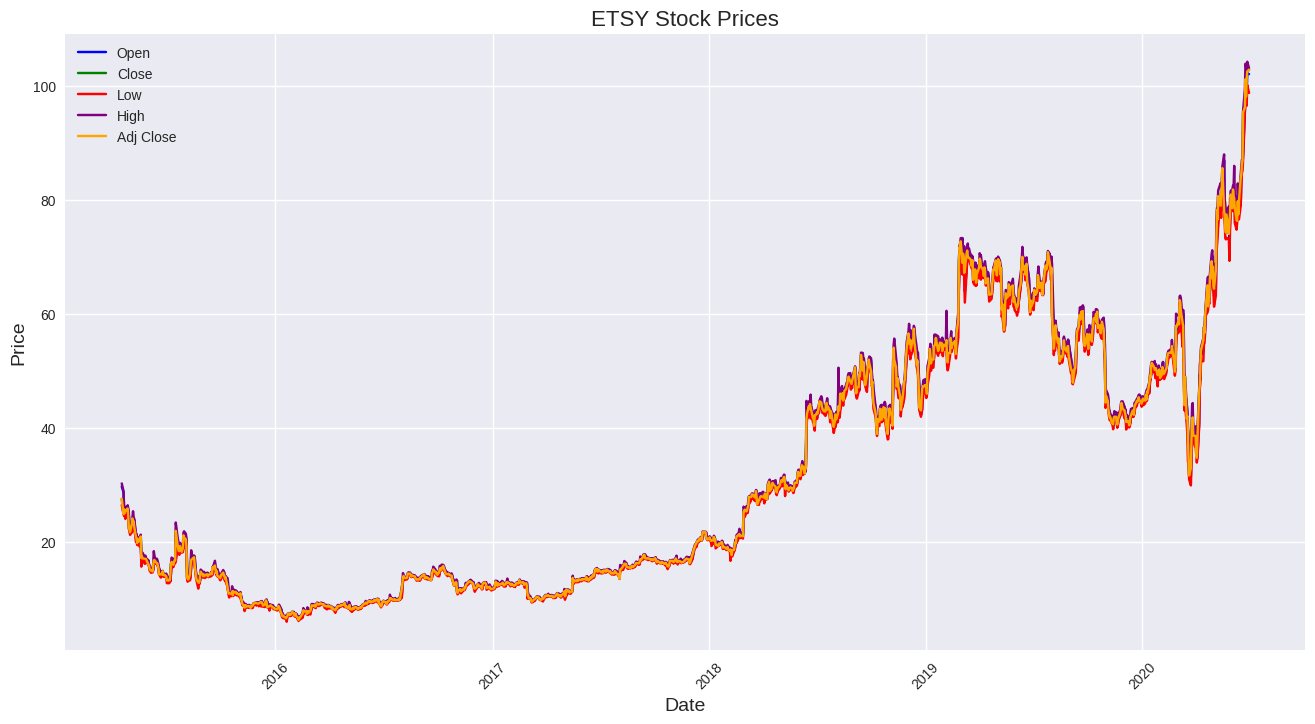

In [12]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('ETSY Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [13]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date       Open      Close        Low       High  Adj Close  \
0 2015-04-20  28.770000  24.900000  24.870001  28.900000  24.900000   
1 2015-04-21  24.969999  25.750000  24.559999  26.040001  25.750000   
2 2015-04-22  26.000000  25.120001  24.950001  26.240000  25.120001   
3 2015-04-23  24.930000  25.620001  24.080000  25.740000  25.620001   
4 2015-04-24  25.549999  25.580000  25.000000  25.700001  25.580000   

   avg_price   returns  
0  26.468000 -6.631860  
1  25.414000 -3.982169  
2  25.486001  0.283312  
3  25.198000 -1.130033  
4  25.482000  1.127072  


In [14]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date       Open      Close        Low       High  Adj Close   returns
0 2015-04-20  28.770000  24.900000  24.870001  28.900000  24.900000 -6.631860
1 2015-04-21  24.969999  25.750000  24.559999  26.040001  25.750000 -3.982169
2 2015-04-22  26.000000  25.120001  24.950001  26.240000  25.120001  0.283312
3 2015-04-23  24.930000  25.620001  24.080000  25.740000  25.620001 -1.130033
4 2015-04-24  25.549999  25.580000  25.000000  25.700001  25.580000  1.127072


In [15]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (1309, 7)
[[Timestamp('2015-04-20 00:00:00') 28.77 24.9 ... 28.9 24.9
  -6.6318597899806875]
 [Timestamp('2015-04-21 00:00:00') 24.969999 25.75 ... 26.040001 25.75
  -3.9821686264004064]
 [Timestamp('2015-04-22 00:00:00') 26.0 25.120001 ... 26.24 25.120001
  0.28331156278673664]
 ...
 [Timestamp('2020-06-25 00:00:00') 98.300003 101.279999 ... 102.389999
  101.279999 0.42999497582780766]
 [Timestamp('2020-06-26 00:00:00') 102.269997 102.540001 ... 104.279999
  102.540001 2.397863430835123]
 [Timestamp('2020-06-29 00:00:00') 102.110001 102.889999 ... 103.139999
  102.889999 -0.3858891562491862]]


In [16]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (1309, 6)
[[ 28.77        24.9         24.870001    28.9         24.9
   -6.63185979]
 [ 24.969999    25.75        24.559999    26.040001    25.75
   -3.98216863]
 [ 26.          25.120001    24.950001    26.24        25.120001
    0.28331156]
 ...
 [ 98.300003   101.279999    96.57       102.389999   101.279999
    0.42999498]
 [102.269997   102.540001   100.175003   104.279999   102.540001
    2.39786343]
 [102.110001   102.889999    98.800003   103.139999   102.889999
   -0.38588916]]


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(1243, 6)
(33, 6)
(33, 6)


In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 1242
Validation Samples: 32
Test Samples: 32


In [23]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [24]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(1242,) (32,) (32,)


In [25]:
x_train[1], y_train[0]

(array([[0.27794379, 0.29197411, 0.28300731, 0.28880705, 0.29197411,
         0.41811737]]),
 0.27794379441207717)

In [26]:
x_val[1], y_val[0]

(array([[0.50627614, 0.48652311, 0.48945597, 0.50529953, 0.48652311,
         0.3644181 ]]),
 0.5062761430622215)

In [27]:
x_test[1], y_test[0]

(array([[1.10699336, 1.13341365, 1.12622241, 1.14786137, 1.13341365,
         0.51383524]]),
 1.1069933636133686)

In [28]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [29]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, Dense, Dropout, Reshape, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np

In [30]:
%%time
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]

    x_train_reshaped = x_train.reshape((x_train.shape[0], n_timesteps, 1, n_features, 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], n_timesteps, 1, n_features, 1))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         input_shape=(n_timesteps, 1, n_features, 1),
                         return_sequences=True, padding='same'))

    model.add(Reshape((-1, 64)))
    model.add(Flatten())
    # Change the number of units in the Dense layer to match the shape of y_train or y_val
    model.add(Dense(units=1))  # Output a single value for each input
    model.add(Dropout(0.2))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-07-03 10:19:52,293] A new study created in memory with name: no-name-14e259dc-97d2-446f-966d-d83990b3c271


1/1 [==============================] - 0s 394ms/step


[I 2024-07-03 10:20:25,886] Trial 0 finished with value: 0.17906234680712876 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.004777104741797647, 'epochs': 57, 'batch_size': 64}. Best is trial 0 with value: 0.17906234680712876.


1/1 [==============================] - 0s 378ms/step


[I 2024-07-03 10:20:52,362] Trial 2 finished with value: 0.16219115354036986 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0004791613668699802, 'epochs': 145, 'batch_size': 64}. Best is trial 2 with value: 0.16219115354036986.


1/1 [==============================] - 0s 197ms/step


[I 2024-07-03 10:21:14,846] Trial 3 finished with value: 0.1619549083690985 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.000182228698145264, 'epochs': 136, 'batch_size': 64}. Best is trial 3 with value: 0.1619549083690985.


1/1 [==============================] - 1s 750ms/step


[I 2024-07-03 10:21:21,465] Trial 1 finished with value: 0.1553810235554678 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00016951168504051228, 'epochs': 56, 'batch_size': 16}. Best is trial 1 with value: 0.1553810235554678.


1/1 [==============================] - 0s 213ms/step


[I 2024-07-03 10:21:58,094] Trial 4 finished with value: 0.1649356480104636 and parameters: {'optimizer': 'Adam', 'learning_rate': 3.871801494052421e-05, 'epochs': 139, 'batch_size': 64}. Best is trial 1 with value: 0.1553810235554678.


1/1 [==============================] - 0s 329ms/step


[I 2024-07-03 10:22:06,989] Trial 5 finished with value: 0.14954809375726177 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0005607776839216426, 'epochs': 171, 'batch_size': 16}. Best is trial 5 with value: 0.14954809375726177.


1/1 [==============================] - 1s 810ms/step


[I 2024-07-03 10:22:39,315] Trial 6 finished with value: 0.20464763082033907 and parameters: {'optimizer': 'Adam', 'learning_rate': 2.3716214808852683e-05, 'epochs': 74, 'batch_size': 32}. Best is trial 5 with value: 0.14954809375726177.


1/1 [==============================] - 0s 350ms/step


[I 2024-07-03 10:23:16,421] Trial 8 finished with value: 0.30596992608382784 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 1.6037509409775195e-05, 'epochs': 124, 'batch_size': 32}. Best is trial 5 with value: 0.14954809375726177.


1/1 [==============================] - 0s 338ms/step


[I 2024-07-03 10:24:03,725] Trial 9 finished with value: 0.18703474034608117 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0021821220589105295, 'epochs': 72, 'batch_size': 32}. Best is trial 5 with value: 0.14954809375726177.


1/1 [==============================] - 0s 198ms/step


[I 2024-07-03 10:24:46,176] Trial 7 finished with value: 0.15705005620144669 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.005518391567108947, 'epochs': 181, 'batch_size': 16}. Best is trial 5 with value: 0.14954809375726177.


Best trial: FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.14954809375726177], datetime_start=datetime.datetime(2024, 7, 3, 10, 21, 21, 469182), datetime_complete=datetime.datetime(2024, 7, 3, 10, 22, 6, 989117), params={'optimizer': 'RMSprop', 'learning_rate': 0.0005607776839216426, 'epochs': 171, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=5, value=None)
CPU times: user 6min 43s, sys: 28.8 s, total: 7min 12s
Wall time: 4min 53s


In [31]:
best_params = study.best_params
best_params

{'optimizer': 'RMSprop',
 'learning_rate': 0.0005607776839216426,
 'epochs': 171,
 'batch_size': 16}

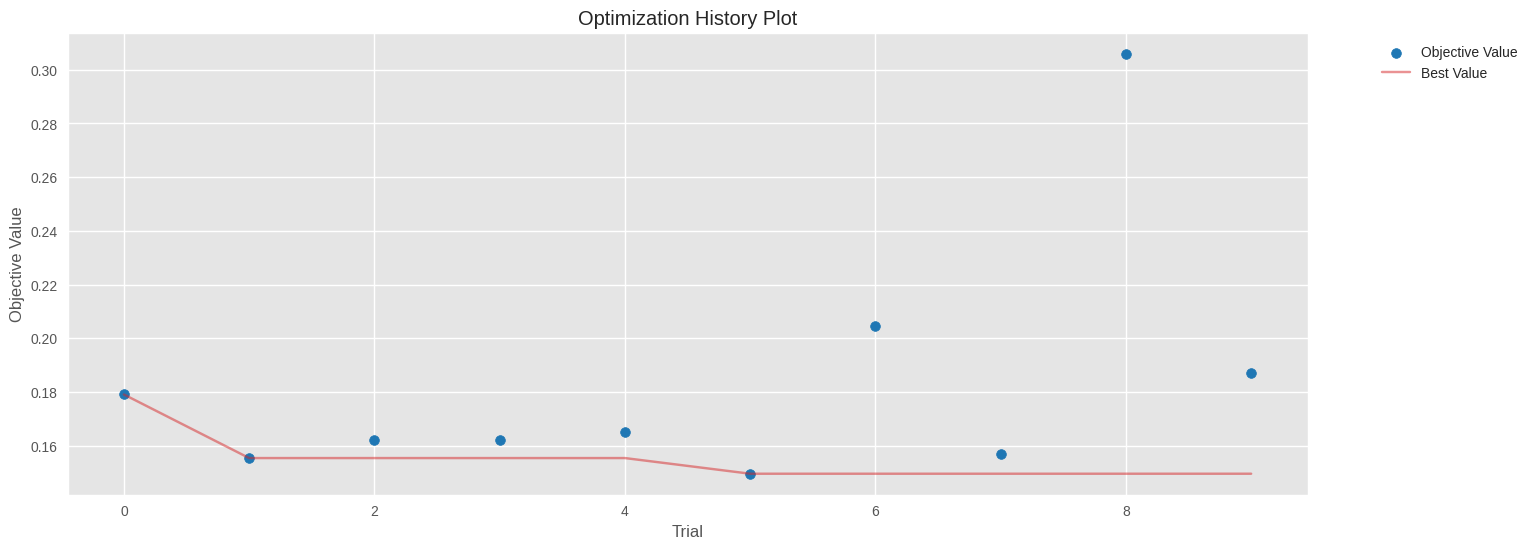

In [32]:
plot_optimization_history(study);

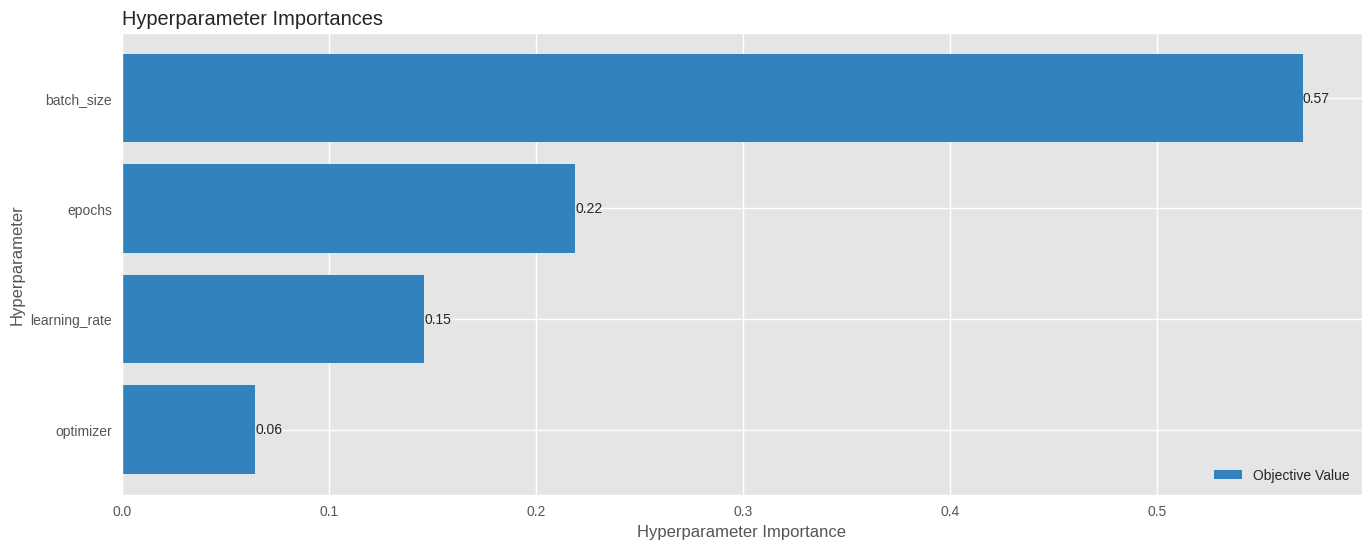

In [33]:
plot_param_importances(study);

In [34]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [40]:
# Define the LSTM model using the best hyperparameters
model = Sequential()
# Check if 'units' is in best_params, if not, provide a default value
units = best_params.get("units", 64)  # Default to 64 units if not found
model.add(LSTM(units=units, input_shape=(x_train.shape[1], x_train.shape[2])))

# Check if 'dropout_rate' exists in best_params before using it
if 'dropout_rate' in best_params:
    model.add(Dropout(rate=best_params["dropout_rate"]))

model.add(Dense(units=1))

# Compile the model with the best optimizer and learning rate
if best_params['optimizer'] == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


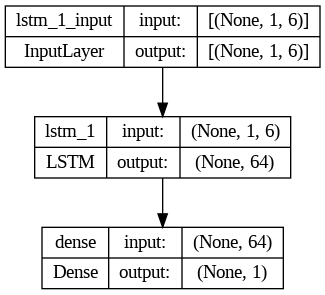

In [41]:
plot_model(model, show_shapes=True)

In [42]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 59.3 s, sys: 4.01 s, total: 1min 3s
Wall time: 51.5 s


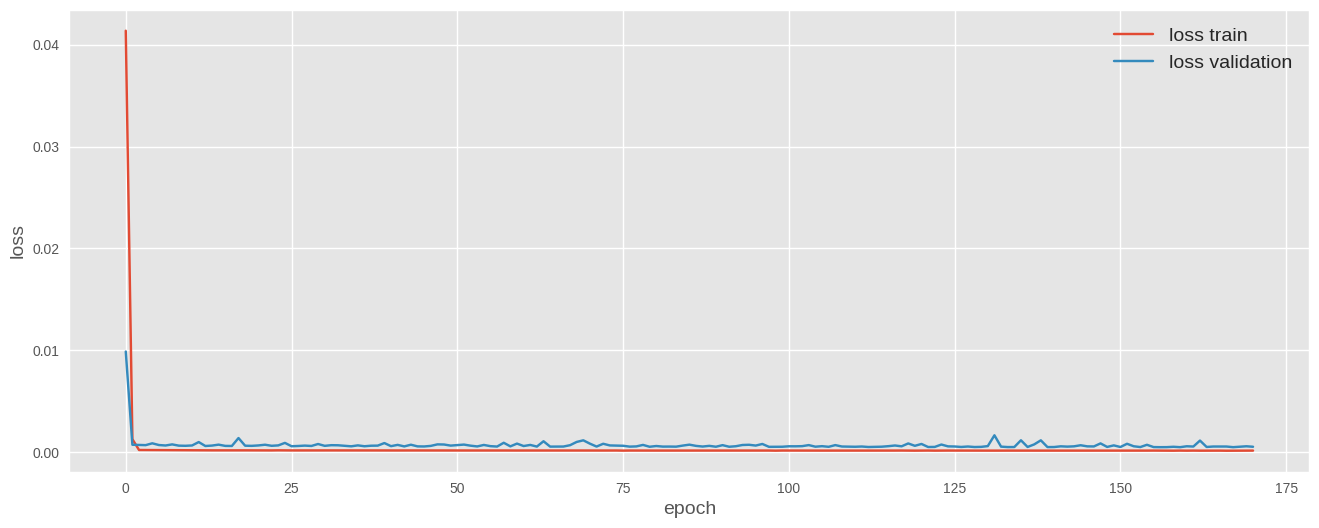

In [43]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [44]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

2/2 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 0.0000e+00


[0.0013478010660037398, 0.0]

In [45]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

1/1 [==============================] - 0s 18ms/step


In [46]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(1242,) (32,)


In [47]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [25.32579058 25.31920516 25.21139343 25.18509964 25.44470099]
Train Actual:  [25. 26. 25. 26. 26.]
Test Predicted:  [79.84609825 80.52102545 83.54246628 78.6534003  76.35704911]
Test Actual:  [80. 82. 87. 79. 79.]


In [48]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.81 RMSE
Test Score: 2.45 RMSE


In [49]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

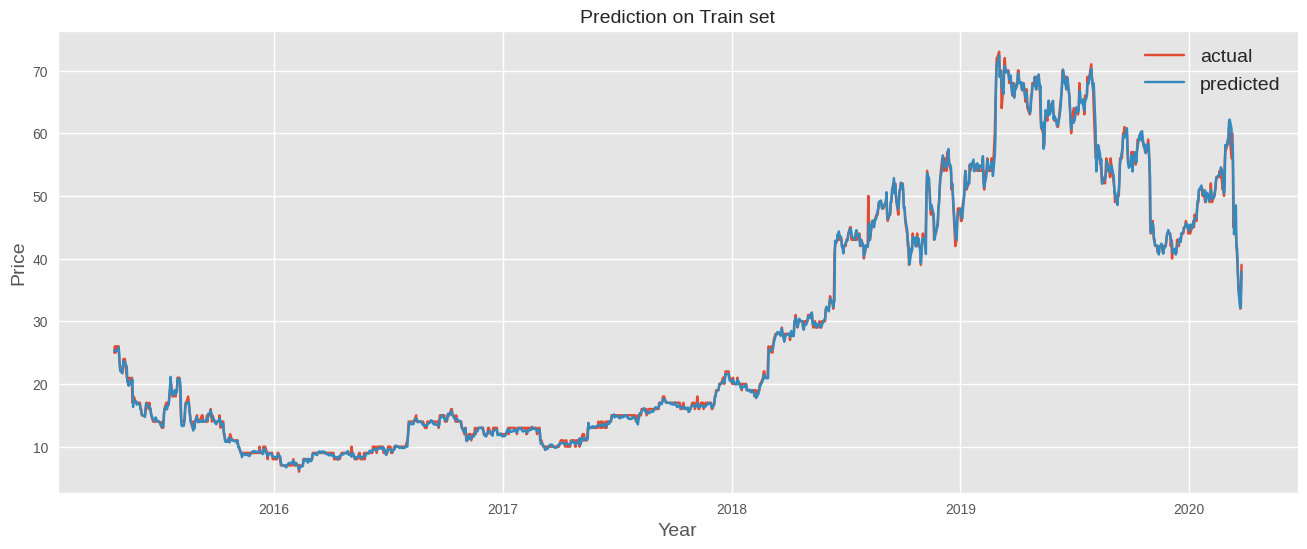

In [50]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

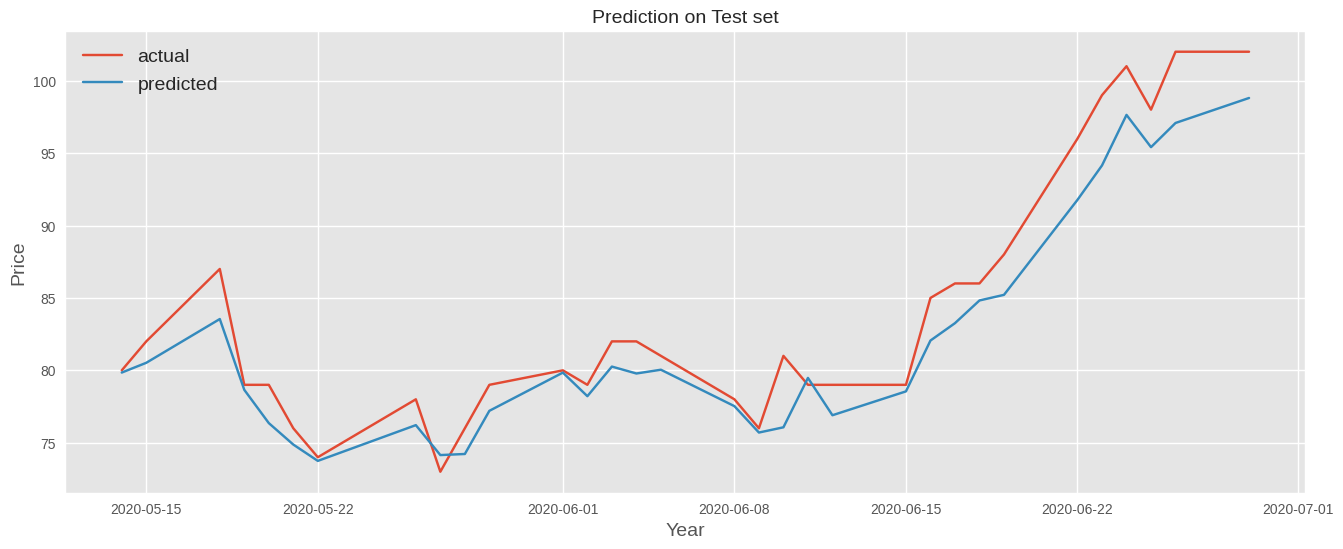

In [51]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [52]:
yhat_test

array([79.84609825, 80.52102545, 83.54246628, 78.6534003 , 76.35704911,
       74.87556619, 73.74781295, 76.21712401, 74.14996599, 74.22407683,
       77.20436979, 79.84400815, 78.21487791, 80.25941179, 79.78253364,
       80.04250395, 77.52729841, 75.70476999, 76.06699571, 79.47655717,
       76.90014039, 78.54759491, 82.05783225, 83.25719937, 84.82515824,
       85.2123136 , 91.77460936, 94.14796722, 97.63810129, 95.41042828,
       97.08016391, 98.80610892])

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 5.987802362122787
Root Mean Squared Error (RMSE): 2.4469986436699935
Mean Absolute Error (MAE): 1.979297397019522
R-squared (R2) Score: 0.9150995621875695
Mean Absolute Percentage Error (MAPE): 2.27%


In [54]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: 2.05%
Mean Squared Error (MSE) on Training set: 0.66
Root Mean Squared Error (RMSE) on Training set: 0.81
Mean Absolute Error (MAE) on Training set: 0.47
R-squared (R2) Score on Training set: 1.00


In [55]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.98


In [56]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: 0.98
